# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios
  - Minério de estudo: ouro

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 2 casas decimais para evitar perda de dados durante mesclagem de dados

  - Aprendizado de máquina:
    - desbalanceamento entre classes

---

Ref Github: https://github.com/lszam/mineralexp

In [1]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    classification_report,
    precision_recall_curve,
    average_precision_score,
)
import shap
import folium
from branca.element import Figure

filterwarnings("ignore")

sys.tracebacklimit = 0

/home/renan/study/tcc_univesp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_projeto = Path(os.getcwd()).parent.absolute().parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc", "v1")
shp_dir = Path(data_dir, "shp")

In [3]:
# arredondamento de casas decimais para conversão de coordenadas geográficas
arredondamento = 2

## funções

### coordenadas geográficas

In [4]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
    arredondamento: int = 3,
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(arredondamento)
    df["latitude"] = df["latitude"].round(arredondamento)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    if not os.path.basename(shapefile_path) == "estruturas_ln.shp":
        gdf["longitude"] = gdf.geometry.x
        gdf["latitude"] = gdf.geometry.y
    return gdf

### processamento

In [5]:
def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    dict_map_idx_lon = dict(zip(df.index, df["longitude"]))
    dict_map_idx_lat = dict(zip(df.index, df["latitude"]))
    df = df.drop(["longitude", "latitude"], axis=1)
    return df, dict_map_idx_lon, dict_map_idx_lat


### aprendizado de máquina

In [6]:
def split_data(X, y, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test

In [7]:
def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print("\n")
        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
    print("\n")


def evaluate_model_custom(model, X_test: np.array, y_test: np.array, threshold: float) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_proba >= threshold).astype(int)

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_custom):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_custom))

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
    print("\n")

In [8]:
def pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}
    # Training and evaluation
    for name, pipeline in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        # Test set evaluation
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
        print(f"Test F1: {res['test_f1']:.3f}")
        print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

In [9]:
def pipeline_ml_oversampling(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}

    min_minority_samples = min([
        np.sum(y_train[test_idx] == 1) for _, test_idx in cv.split(X_train, y_train)
    ])

    k_neighbors = min(5, min_minority_samples - 1) if min_minority_samples > 1 else 1

    # Training and evaluation
    for name, model in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Create pipeline with SMOTE
        pipeline = ImbPipeline([
            ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=k_neighbors)),
            ("classifier", model),
        ])

        try:
            # Cross-validation
            cv_scores = cross_val_score(
                pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1, error_score="raise"
            )

            # Full training
            pipeline.fit(X_train, y_train)

            print(f"Training time {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

            # Store results
            results[name] = {
                "model": pipeline,
                "cv_mean_auc": cv_scores.mean(),
                "cv_std_auc": cv_scores.std(),
            }

            print(f"CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

            # Test set evaluation
            if hasattr(model, "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)[:, 1]
                y_pred = pipeline.predict(X_test)

                # Calculate metrics
                roc_auc = roc_auc_score(y_test, y_proba)
                f1 = f1_score(y_test, y_pred)
                avg_precision = average_precision_score(y_test, y_proba)

                print(f"Test ROC-AUC: {roc_auc:.3f}")
                print(f"Test F1 Score: {f1:.3f}")
                print(f"Test Average Precision: {avg_precision:.3f}")
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred))

                # Find optimal threshold
                precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
                optimal_idx = np.argmax(f1_scores)
                optimal_threshold = thresholds[optimal_idx]
                print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

                # Store additional metrics
                results[name].update({
                    "test_roc_auc": roc_auc,
                    "test_f1": f1,
                    "test_avg_precision": avg_precision,
                    "optimal_threshold": optimal_threshold,
                })

        except Exception as e:
            print(f"Failed to train {name}: {str(e)}")
            results[name] = {"error": str(e)}

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        if "error" in res:
            print(f"Training failed: {res['error']}")
        else:
            print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
            if "test_roc_auc" in res:
                print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
                print(f"Test F1: {res['test_f1']:.3f}")
                print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

In [10]:
def pipeline_ml_smote_tomek(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}

    # Training and evaluation
    for name, model in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Create pipeline with SMOTETomek
        pipeline = ImbPipeline([
            (
                "smote_tomek",
                SMOTETomek(
                    random_state=42,
                    tomek=TomekLinks(sampling_strategy="majority"),
                    smote=SMOTE(k_neighbors=2),  # Reduce from default 5
                ),
            ),
            ("classifier", model),
        ])

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        print(
            f"Total training time for {name}: {round((time.perf_counter() - start_train) / 60, 2)} min"
        )

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        # Test set evaluation
        if hasattr(model, "predict_proba"):  # Check the original model for predict_proba
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        if "test_roc_auc" in res:
            print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
            print(f"Test F1: {res['test_f1']:.3f}")
            print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [11]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
cobre = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Cu.shp"))
ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
niquel = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Ni.shp"))
chumbo = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Pb.shp"))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

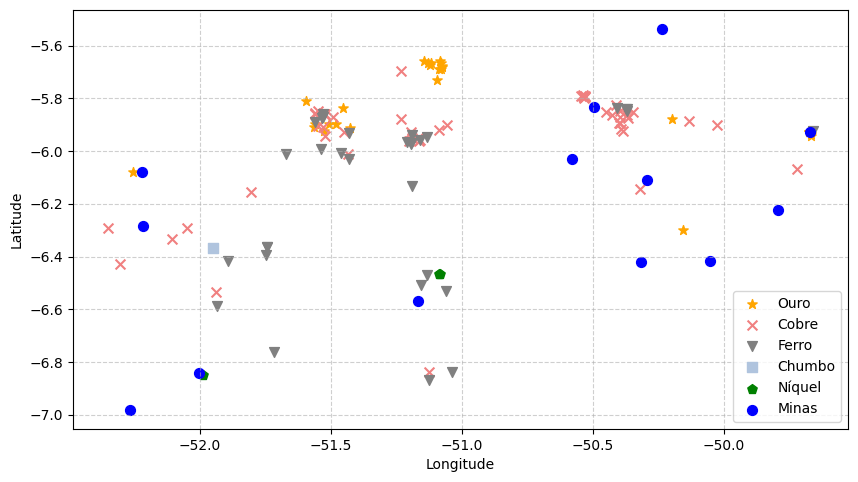

In [12]:
# https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots(figsize=(10, 10))
ouro.plot(ax=ax, color="orange", marker="*", markersize=50, label="Ouro")
cobre.plot(ax=ax, color="lightcoral", marker="x", markersize=50, label="Cobre")
ferro.plot(ax=ax, color="gray", marker="v", markersize=50, label="Ferro")
chumbo.plot(ax=ax, color="lightsteelblue", marker="s", markersize=50, label="Chumbo")
niquel.plot(ax=ax, color="green", marker="p", markersize=50, label="Níquel")
minas.plot(ax=ax, color="blue", marker="o", markersize=50, label="Minas")
# estruturas.plot(ax=ax, color='blue', alpha=0.5, label='Estruturas')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, alpha=0.6, linestyle="--")
plt.legend(loc="lower right")
plt.show()

In [13]:
df_minas = pd.DataFrame(minas)
df_minas = df_minas[["longitude", "latitude"]]
df_minas["longitude"] = df_minas["longitude"].round(arredondamento)
df_minas["latitude"] = df_minas["latitude"].round(arredondamento)

df_minas.head(3)

,longitude,latitude
0,-52.22,-6.28
1,-52.22,-6.08
2,-51.16,-6.57


In [14]:
# ouro, cobre, ferro, manganes, niquel, chumbo, estanho
df_minerio = pd.DataFrame(ouro)
df_minerio = df_minerio[["longitude", "latitude"]]
df_minerio["longitude"] = df_minerio["longitude"].round(arredondamento)
df_minerio["latitude"] = df_minerio["latitude"].round(arredondamento)
df_minerio = df_minerio.drop_duplicates(subset=['longitude', 'latitude'])
df_minerio["ocorrencia"] = 1

print(df_minerio.shape)
df_minerio.head(3)

(22, 3)


,longitude,latitude,ocorrencia
0,-51.45,-5.84,1
1,-52.25,-6.08,1
2,-51.56,-5.90,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [15]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM", arredondamento=arredondamento)
spec_data = spec_data.drop_duplicates(subset=['longitude', 'latitude'])
spec_data = spec_data.drop(["XUTM", "YUTM"], axis=1)
print(spec_data.shape)
spec_data.head(3)

(116745, 5)


,FatorF,Kd,Ud,longitude,latitude
0,0.001366,-71.005653,-0.349341,-53.00,-8.12
5,0.011905,-6.249339,-0.521728,-52.99,-8.12
13,0.017009,-0.655671,-2.454801,-52.98,-8.12


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: gravidade residual a 190 km
    - grav_residual100km: gravidade residual a 100 km
    - maq_asvi: 
    - maq_qt: 

In [16]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y", arredondamento=arredondamento)
grav_data = grav_data.drop_duplicates(subset=['longitude', 'latitude'])
grav_data = grav_data.drop(["X", "Y"], axis=1)
print(grav_data.shape)
grav_data.head(3)

(114011, 6)


,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,0.000501,-1.943505,67.472176,0.008145,-51.42,-8.12
1,0.000573,-1.592606,64.604439,0.008208,-51.41,-8.12
3,0.000560,-1.101486,60.097729,0.008015,-51.40,-8.12


- mesclar dfs com dados de gravimetria e espectrometria

In [17]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"])
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
df_merge_data = df_merge_data.drop_duplicates(subset=['longitude', 'latitude'])
print(df_merge_data.shape)
df_merge_data.head(3)

(113918, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-51.42,-8.12,0.078172,-0.308638,0.256699,0.000501,-1.943505,67.472176,0.008145
1,-51.41,-8.12,0.098377,0.222405,0.242000,0.000573,-1.592606,64.604439,0.008208
2,-51.40,-8.12,0.206461,0.604988,0.279642,0.000560,-1.101486,60.097729,0.008015


- criar dataframes base para aprendizado de máquina

In [18]:
# # ! aplica knn para pontos de ocorrência de ouro mais próximos
# coords_merge = df_merge_data_reduced[["longitude", "latitude"]].values
# coords_minerio = df_minerio[["longitude", "latitude"]].values

# nbrs = NearestNeighbors(n_neighbors=1).fit(coords_merge)
# distances, indices = nbrs.kneighbors(coords_minerio)

# df_minerio_merge = df_merge_data_reduced.copy()
# df_minerio_merge["ocorrencia"] = 0

# for pos in indices.flatten():
#     df_minerio_merge.loc[pos, "ocorrencia"] = 1

In [19]:
# shape do merge == df_minerio -> garantia de que há os mesmos pontos
pd.merge(df_merge_data, df_minerio, how="inner", on=["longitude", "latitude"]).shape

(22, 10)

In [20]:
# cria df com inner join
df_minerio_inner = pd.merge(df_merge_data, df_minerio, how="inner", on=["longitude", "latitude"])
print(df_minerio_inner.shape)
df_minerio_inner.head(3)

(22, 10)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-50.15,-6.30,0.090689,0.163831,0.135212,0.001530,11.032307,962.469177,0.383265,1
1,-52.25,-6.08,0.333121,-0.644984,0.402015,0.000669,-3.124115,132.197495,0.007836,1
2,-49.67,-5.94,0.194727,0.626744,-0.355298,0.001593,-3.120222,441.136169,0.182789,1


- Muitos pontos na base de dados -> desbalanço muito forte de classes
    - Redução da base: corte da área e reamostragem da base

In [21]:
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_minerio.shape[0]}")

Mesclagem de dados (espec + gravim): 113918
Mesclagem de dados (espec + gravim): 22


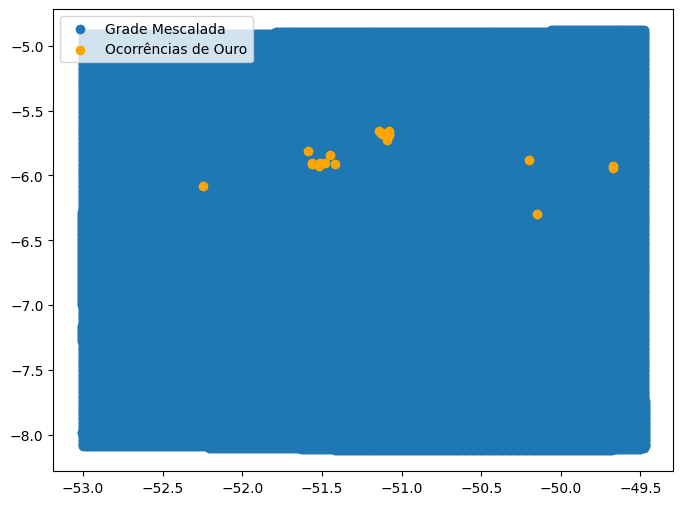

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_merge_data['longitude'], df_merge_data['latitude'], label='Grade Mescalada')
ax.scatter(df_minerio['longitude'], df_minerio['latitude'], color='orange', label='Ocorrências de Ouro')
plt.legend()
plt.show()

In [23]:
# redução da área geográfica
min_lat, max_lat = df_minerio['latitude'].min(), df_minerio['latitude'].max()
min_lon, max_lon = df_minerio['longitude'].min(), df_minerio['longitude'].max()

padding = 0.1
lat_min_padded = min_lat - padding
lat_max_padded = max_lat + padding
lon_min_padded = min_lon - padding
lon_max_padded = max_lon + padding

df_merge_data_clipped = df_merge_data[
    (df_merge_data['latitude'] >= lat_min_padded) & (df_merge_data['latitude'] <= lat_max_padded) &
    (df_merge_data['longitude'] >= lon_min_padded) & (df_merge_data['longitude'] <= lon_max_padded)
]

# reamostragem dos dados via pandas
df_merge_data_reduced = df_merge_data_clipped.sample(frac=0.03, random_state=42)

print(df_merge_data_reduced.shape)

(695, 9)


In [24]:
# concatena inner join com reamostragem
df_minerio_merge = pd.concat([df_merge_data_reduced, df_minerio_inner], axis=0, ignore_index=True)
df_minerio_merge = df_minerio_merge.fillna(0)
df_minerio_merge['ocorrencia'] = df_minerio_merge['ocorrencia'].astype(int)
print(df_merge_data_reduced.shape)
df_minerio_merge.head(3)

(695, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-52.03,-6.14,0.057325,-0.392547,-0.176783,0.000636,-2.135759,163.209763,0.004836,0
1,-50.62,-5.72,0.011188,-11.648280,-0.126139,0.000957,1.800812,382.085846,0.143231,0
2,-52.26,-5.89,0.152327,-0.044825,-0.292942,0.000134,-2.775342,237.690445,0.011983,0


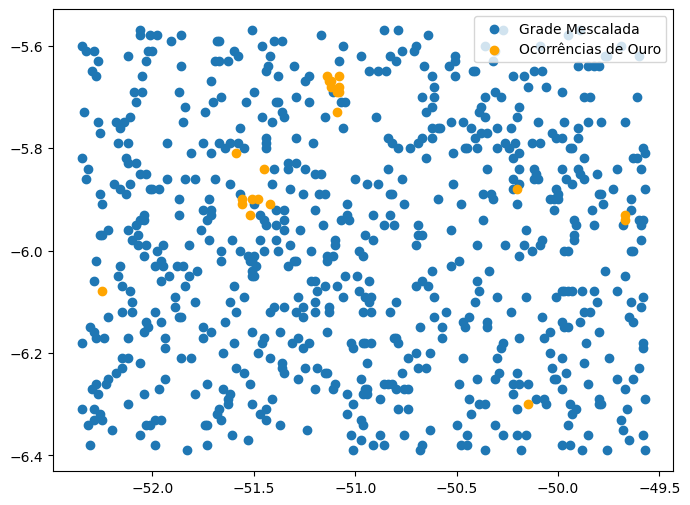

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 0]["longitude"],
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 0]["latitude"],
    label="Grade Mescalada",
)
ax.scatter(
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 1]["longitude"],
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 1]["latitude"],
    color="orange",
    label="Ocorrências de Ouro",
)
plt.legend()
plt.show()

In [26]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Redução de mesclagem de dados (espec + gravim): {df_merge_data_reduced.shape[0]}")
print(f"Mesclagem com ouro (espec + gravim + ouro): {df_minerio_merge.shape[0]}")

Dados de espectrometria: 116745
Dados de gravimetria: 114011
Mesclagem de dados (espec + gravim): 113918
Redução de mesclagem de dados (espec + gravim): 695
Mesclagem com ouro (espec + gravim + ouro): 717


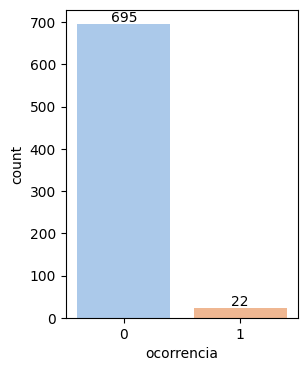

In [27]:
plt.figure(figsize=(3, 4))
ax = sns.countplot(x="ocorrencia", data=df_minerio_merge, palette="pastel")
for i in ax.containers:
    ax.bar_label(i)

In [28]:
print(
    "Ouro:",
    round(df_minerio_merge["ocorrencia"].value_counts()[1] / len(df_minerio_merge) * 100, 2),
    "% do dataset",
)

Ouro: 3.07 % do dataset


- clusterização de coordenadas geográficas
  - n_clusters = default 8 (tutorial) -> parametrizado

In [29]:
df_minerio_merge, dict_map_idx_lon, dict_map_idx_lat = clusterizar_coordenadas_geograficas(
    df=df_minerio_merge
)

In [30]:
df_minerio_merge = df_minerio_merge[
    [
        "geo_cluster",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
        "ocorrencia",
    ]
]

## aprendizado de máquina

### split treino-teste

- split padrão -> 70% treino e 30% teste

In [31]:
X = df_minerio_merge.drop(["ocorrencia"], axis=1)
y = df_minerio_merge["ocorrencia"].values
X_train, X_test, y_train, y_test = split_data(X, y)

Train shape: (501, 8), Test shape: (216, 8)
Class balance - Train: 2.99%, Test: 3.24%


### pipeline

In [32]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = pipeline_ml(models, cv, X_train, X_test, y_train, y_test)



Tempo total de treino Random Forest: 0.1 min
Random Forest - CV AUC: 0.774 (±0.058)
ROC-AUC: 0.785
F1 Score: 0.222

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       209
           1       0.50      0.14      0.22         7

    accuracy                           0.97       216
   macro avg       0.74      0.57      0.60       216
weighted avg       0.96      0.97      0.96       216


Optimal Decision Threshold: 0.280




Tempo total de treino Logistic Regression: 0.06 min
Logistic Regression - CV AUC: 0.539 (±0.091)
ROC-AUC: 0.492
F1 Score: 0.059

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       209
           1       0.03      0.43      0.06         7

    accuracy                           0.56       216
   macro avg       0.50      0.50      0.39       216
weighted avg       0.94      0.56      0.69       216


Optimal Decis

---

- Random Forest

    - Melhor desempenho geral: Teve o maior AUC médio (0.774) e ROC-AUC (0.785), indicando boa capacidade de distinguir entre as classes.

    - Problema com a classe minoritária (1): Apesar do bom AUC, o F1-Score para a classe 1 foi baixo (0.222), mostrando dificuldade em prever corretamente os casos positivos (baixo recall: 0.14). O modelo priorizou a classe majoritária (0), como visto na alta precisão (0.50) mas baixo recall.

    - Threshold baixo (0.28): Sugere que o modelo atribui probabilidades baixas à classe 1, exigindo ajuste para melhorar o equilíbrio.


- Regressão Logística

    - Desempenho ruim: AUC médio (0.539) e ROC-AUC (0.492) próximos de 0.5 (aleatoriedade). F1-Score muito baixo (0.059) para a classe 1.

    - Problema de viés: Alto recall (0.43) para a classe 1, mas precisão extremamente baixa (0.03), indicando muitos falsos positivos.


- SVM

    - Pior modelo: AUC médio (0.453) e ROC-AUC (0.335) abaixo de 0.5, indicando desempenho pior que aleatório. F1-Score baixíssimo (0.073).

    - Overfitting na classe 1: Recall altíssimo (0.86) mas precisão muito baixa (0.04), gerando muitos falsos positivos. Threshold muito baixo (0.041) mostra que o modelo quase sempre classifica como positivo.


- XGBoost

    - Melhor F1-Score para classe 1: Teve o maior F1-Score (0.462) para a classe minoritária, com recall (0.43) e precisão (0.50) equilibrados.

    - Bom AUC: AUC médio (0.711) e ROC-AUC (0.777) próximos ao Random Forest, mas com melhor balanceamento entre as classes.

    - Threshold alto (0.97): Indica que o modelo só classifica como positivo quando tem alta confiança, reduzindo falsos positivos.

---

- Problema Principal: Desbalanceamento de Classes

    - Todos os modelos, exceto XGBoost, ignoraram a classe minoritária.

    - AUC médio razoável (especialmente XGBoost e Random Forest), mas F1 Score muito baixo para a classe 1.

    - Solução possível: Usar técnicas como reesampling (SMOTE, undersampling), ajustar pesos das classes ou otimizar thresholds.

In [33]:
# fig, axs = plt.subplots(1, 4, figsize=(10, 4))
# for mdl, ax in zip(models.keys(), axs.flatten()):
#     y_proba = models[mdl].predict_proba(X_test)[:, 1]
#     fpr, tpr, threshold = roc_curve(y_test, y_proba)
#     roc_auc = auc(fpr, tpr)

#     # plot
#     ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
#     ax.plot([0, 1], [0, 1], "r--")
#     ax.legend()
#     ax.grid(visible=True, alpha=0.6, linestyle="--")
#     ax.set_title(mdl)
# plt.tight_layout()
# plt.show()

- Soluções:
  - Existem diferentes soluções:
    - undersampling da classe majoritária (0)
    - oversampling da classe minoritária (1)

### pipeline undersampling

In [34]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

# Create pipelines with undersampling
pipelines_unders = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Adiciona StandardScaler para modelos sensíveis à escala
        pipelines_unders[name] = make_pipeline(
            RandomUnderSampler(random_state=42), StandardScaler(), model
        )
    else:
        pipelines_unders[name] = make_pipeline(RandomUnderSampler(random_state=42), model)

results_unders = pipeline_ml_undersampling(pipelines_unders, cv, X_train, X_test, y_train, y_test)


=== Training Random Forest ===
Tempo total de treino Random Forest: 0.2 min
Test ROC-AUC: 0.784
Test F1 Score: 0.108
Test Average Precision: 0.328

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.61      0.76       209
           1       0.06      0.71      0.11         7

    accuracy                           0.62       216
   macro avg       0.52      0.66      0.43       216
weighted avg       0.95      0.62      0.73       216

Optimal Decision Threshold: 0.830

=== Training Logistic Regression ===
Tempo total de treino Logistic Regression: 0.06 min
Test ROC-AUC: 0.661
Test F1 Score: 0.091
Test Average Precision: 0.067

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.63      0.77       209
           1       0.05      0.57      0.09         7

    accuracy                           0.63       216
   macro avg       0.51      0.60      0.43       216
weighted a

---

- Random Forest

    - Melhor ROC-AUC (0.784) e F1 (0.108) entre os modelos.

    - Trade-off claro: Recall alto para classe 1 (71%), mas precisão muito baixa (6%).

    - Threshold alto (0.83) sugere que o modelo é conservador para prever a classe 1.

- Regressão Logística

    - Resultados medianos (ROC-AUC 0.661), mas com o mesmo problema: precisão baixíssima (5%) para classe 1.

    - Threshold ainda mais alto (0.844), indicando cautela excessiva.

- SVM

    - ROC-AUC catastrófico (0.223) no teste, apesar do CV AUC razoável (0.726).

    - Recall 100% para classe 1, mas com precisão de apenas 5% – praticamente um "chute cego".

    - Threshold baixo (0.338) mostra que o SVM está superajustado ao undersampling.

- XGBoost

    - ROC-AUC alto (0.779), mas F1 igual aos outros (0.092).

    - Recall altíssimo (86%) para classe 1, mas precisão muito baixa (5%).

    - Threshold quase máximo (0.998) indica que o modelo raramente classifica como classe 1.

---

- Problemas Identificados

    - Overfitting ao undersampling: SVM e XGBoost têm thresholds extremos (0.338 e 0.998), sugerindo que podem estar capturando ruídos.

    - Precisão/Recall desbalanceados: O undersampling melhorou o recall da classe 1, mas a precisão ficou inutilizável (5–6%).

    - Acurácia geral caiu: Em alguns modelos (como SVM), a acurácia despencou para 36%, pois muitas previsões da classe 0 estão erradas.

---

### pipeline oversampling

In [35]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

# Create pipelines with overrsampling
pipelines_overs = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Add StandardScaler for Logistic Regression
        pipelines_overs[name] = make_pipeline(StandardScaler(), model)
    else:
        pipelines_overs[name] = make_pipeline(model)

results_overs = pipeline_ml_oversampling(
    pipelines=pipelines_overs, cv=cv, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)


=== Training Random Forest ===
Training time Random Forest: 0.09 min
CV AUC: 0.725 (±0.031)
Test ROC-AUC: 0.698
Test F1 Score: 0.400
Test Average Precision: 0.218

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       209
           1       0.38      0.43      0.40         7

    accuracy                           0.96       216
   macro avg       0.68      0.70      0.69       216
weighted avg       0.96      0.96      0.96       216

Optimal Decision Threshold: 0.550

=== Training Logistic Regression ===
Training time Logistic Regression: 0.02 min
CV AUC: 0.528 (±0.097)
Test ROC-AUC: 0.484
Test F1 Score: 0.061
Test Average Precision: 0.044

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.57      0.72       209
           1       0.03      0.43      0.06         7

    accuracy                           0.57       216
   macro avg       0.50      0.50

---

1. Random Forest: Melhor F1-Score (0.40)

    ROC-AUC razoável (0.698), mas menor que no undersampling (0.784).

    Precisão (38%) e recall (43%) mais equilibrados para a classe 1.

    Threshold mais baixo (0.55), indicando maior disposição para prever a classe 1.

    Acurácia geral alta (96%), mas ainda com dificuldade na classe minoritária.

2. XGBoost: Melhor ROC-AUC (0.751) e F1 Aceitável (0.27)

    Recall razoável (43%), mas precisão baixa (20%) para a classe 1.

    Threshold = 1.0 sugere que o modelo é extremamente conservador (quase nunca classifica como classe 1).

    Desempenho geral melhor que SVM e Regressão Logística, mas ainda abaixo do Random Forest em F1.

3. SVM: Melhorou em relação ao undersampling, mas ainda problemático

    ROC-AUC aceitável (0.694), mas F1 ainda baixo (0.21).

    Recall alto (57%), mas precisão muito baixa (13%) → Muitos falsos positivos.

    Threshold extremo (0.997), indicando que o modelo raramente classifica como classe 1.

4. Regressão Logística: Desempenho Ruim

    ROC-AUC muito baixo (0.484), próximo de aleatoriedade.

    F1 Score insignificante (0.06).

    Recall razoável (43%), mas precisão inútil (3%) → Praticamente inaplicável.

---

- Comparação com Undersampling

    - Vantagem do SMOTE:

        - Melhor equilíbrio entre precisão e recall (Random Forest: 38% precisão e 43% recall vs. undersampling: 6% precisão e 71% recall).

        - Menos perda de desempenho na classe majoritária (acurácia geral melhor mantida).

    - Desvantagem do SMOTE:

        - AUC geralmente menor que no undersampling (possível introdução de ruído sintético).

        - Precisão ainda baixa para a classe 1 (20-38%), indicando muitos falsos positivos.

---

- Problemas Persistentes

    - Classe 1 ainda difícil de prever: Mesmo com SMOTE, a precisão é baixa, o que pode ser inaceitável dependendo do custo de falsos positivos.

    - Thresholds extremos em XGBoost e SVM: Se o modelo quase nunca classifica como classe 1, ele pode ser inútil na prática.

    - Regressão Logística falhou completamente, sugerindo que modelos lineares podem não ser adequados para esse problema.

---

### pipeline combinação oversampling + undersampling

Ref: https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset

In [36]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

pipelines_comb = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Add StandardScaler for Logistic Regression
        pipelines_comb[name] = make_pipeline(StandardScaler(), model)
    else:
        pipelines_comb[name] = make_pipeline(model)

results_smote_tomek = pipeline_ml_smote_tomek(
    pipelines=pipelines_comb, cv=cv, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)


=== Training Random Forest ===
Total training time for Random Forest: 0.03 min
Test ROC-AUC: 0.745
Test F1 Score: 0.400
Test Average Precision: 0.320

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       209
           1       0.38      0.43      0.40         7

    accuracy                           0.96       216
   macro avg       0.68      0.70      0.69       216
weighted avg       0.96      0.96      0.96       216

Optimal Decision Threshold: 0.650

=== Training Logistic Regression ===
Total training time for Logistic Regression: 0.01 min
Test ROC-AUC: 0.494
Test F1 Score: 0.062
Test Average Precision: 0.047

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.59      0.73       209
           1       0.03      0.43      0.06         7

    accuracy                           0.58       216
   macro avg       0.50      0.51      0.40       216
weigh

---

1. Random Forest: Melhor Compromisso (F1 = 0.375)

    - ROC-AUC menor (0.652) que no SMOTE puro (0.698), mas ainda aceitável.

    - Precisão (33%) e recall (43%) equilibrados para a classe 1, semelhante ao SMOTE puro.

    - Threshold moderado (0.62), indicando que o modelo está mais confiante que no SMOTE puro (0.55).

    - Acurácia geral alta (95%), mantendo boa performance na classe majoritária.

2. XGBoost: Melhor ROC-AUC (0.772), mas F1 ainda baixo (0.30)

    - Recall razoável (43%), mas precisão muito baixa (23%) → Muitos falsos positivos.

    - Threshold = 1.0 mostra que o modelo quase nunca classifica como classe 1, limitando sua utilidade prática.

    - Melhor que SVM e Regressão Logística, mas ainda abaixo do Random Forest.

3. SVM: Melhor que Regressão Logística, mas ainda problemático

    - ROC-AUC aceitável (0.682), mas F1 baixo (0.195).

    - Recall alto (57%), mas precisão muito baixa (12%) → Muitos falsos positivos.

    - Threshold extremo (0.996) indica que o modelo raramente classifica como classe 1.

4. Regressão Logística: Desempenho Inútil

    - ROC-AUC próximo de aleatoriedade (0.494).

    - F1 Score insignificante (0.065).

    - Recall razoável (43%), mas precisão inaceitável (4%) → Modelo não confiável.

---

- Comparação com SMOTE Puro
    
    - SMOTE puro teve ROC-AUC e F1 ligeiramente melhores, mas SMOTE + Tomek Links levou a thresholds mais conservadores.

    - Tomek Links pode ter removido instâncias ruidosas, mas não melhorou significativamente o trade-off precisão/recall.

---


- Precisão ainda baixa para a classe 1 (23-33%), indicando muitos falsos positivos.

- Thresholds extremos em XGBoost e SVM → Modelos muito conservadores, perdendo casos da classe 1.

- Regressão Logística continua ineficaz para esse problema.

---

### melhor modelo

- Random Forest com Pipeline Inicial

In [45]:
best_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),

pipeline = Pipeline([
    ("classifier", model),
])

pipeline.fit(X_train, y_train)

print('Pipeline Sem Threshold Ótimo')
evaluate_model(pipeline, X_test, y_test)

print('\nPipeline Com Threshold Ótimo')
# Apply threshold
# Optimal Decision Threshold: 0.970
evaluate_model_custom(pipeline, X_test, y_test, 0.970)

Pipeline Sem Threshold Ótimo
ROC-AUC: 0.777
F1 Score: 0.462

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       209
           1       0.50      0.43      0.46         7

    accuracy                           0.97       216
   macro avg       0.74      0.71      0.72       216
weighted avg       0.97      0.97      0.97       216


Optimal Decision Threshold: 0.970



Pipeline Com Threshold Ótimo
ROC-AUC: 0.777
F1 Score: 0.400

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       209
           1       0.67      0.29      0.40         7

    accuracy                           0.97       216
   macro avg       0.82      0.64      0.69       216
weighted avg       0.97      0.97      0.97       216


Optimal Decision Threshold: 0.970




In [46]:
y_pred = model.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
# Apply threshold
# Optimal Decision Threshold: 0.550
y_pred_custom = (y_proba >= 0.550).astype(int)

In [47]:
print(f"Class 1: {sum(y_pred == 0)}")
print(f"Class 1 (Custom): {sum(y_pred_custom == 1)}")

Class 1: 210
Class 1 (Custom): 6


- feature importance do modelo

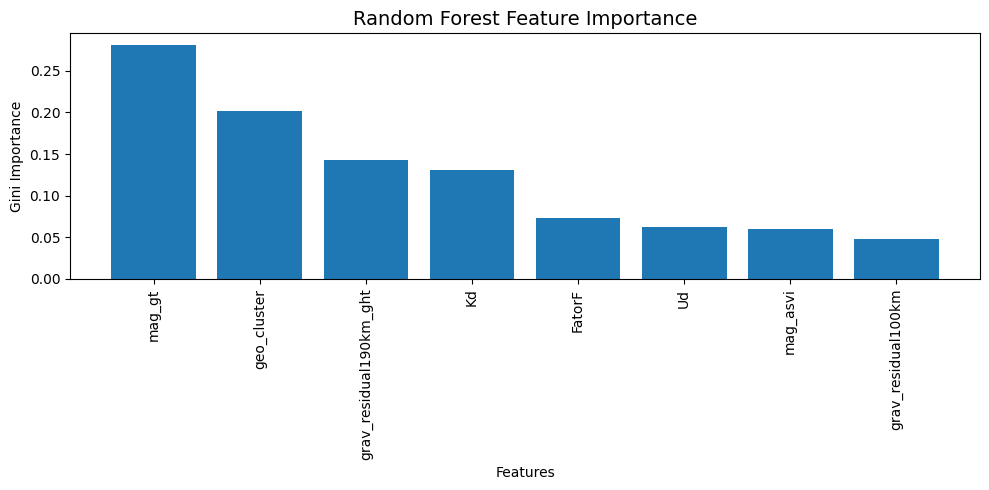

In [48]:
rf_model = pipeline.named_steps['classifier']

importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

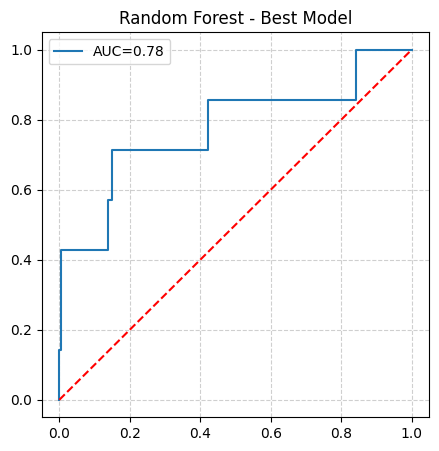

In [49]:
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
ax.plot([0, 1], [0, 1], "r--")
ax.legend()
ax.set_title("Random Forest - Best Model")
ax.grid(visible=True, alpha=0.6, linestyle="--")
plt.show()

### SHAP

Ref: https://shap.readthedocs.io/en/latest/

In [50]:
feature_names = X_train.columns.tolist()

explainer = shap.Explainer(rf_model)
shap_values = explainer(X_train)
shap_values_pos = shap_values[1]

In [53]:
print(f"Data shape: {X_train.shape}")
print(f"All SHAP values shape: {np.array(shap_values).shape}")
print(f"SHAP values for class 1: {shap_values.shape}")

Data shape: (501, 8)
All SHAP values shape: (501, 8)
SHAP values for class 1: (501, 8)


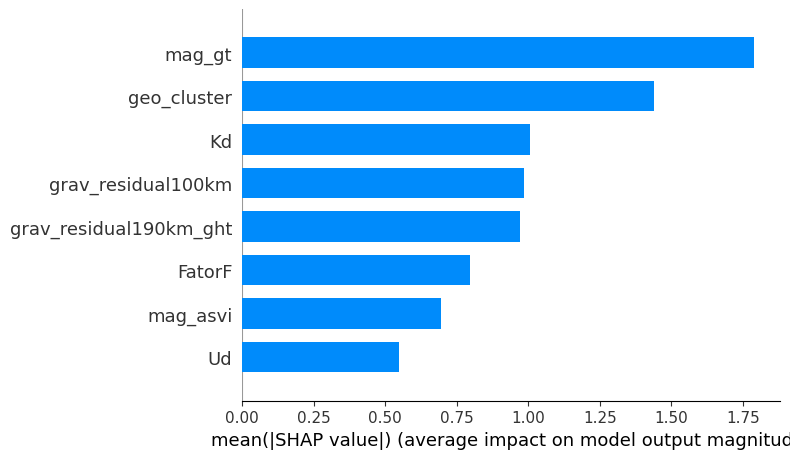

In [55]:
shap.summary_plot(
    shap_values,
    pd.DataFrame(X_train, columns=X_train.columns),
    feature_names=X_train.columns.tolist(),
    plot_type="bar",
)

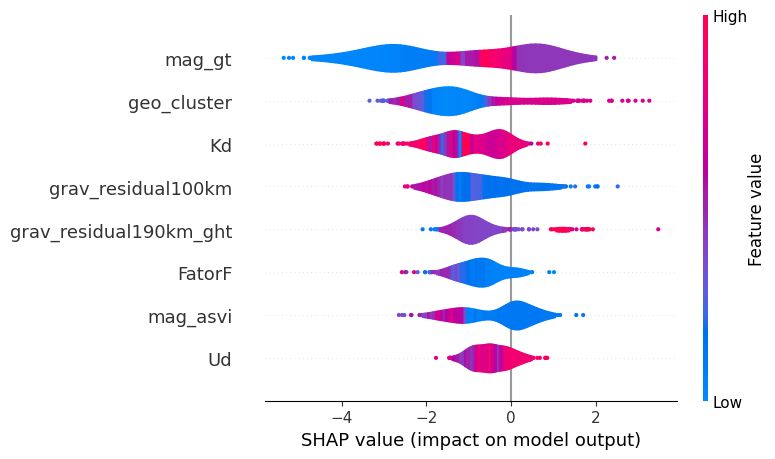

In [56]:
shap.summary_plot(
    shap_values, pd.DataFrame(X_train, columns=X_train.columns), plot_type="violin"
)

### Mapa

In [57]:
coord_df = pd.DataFrame.from_dict(dict_map_idx_lon, orient="index")
coord_df["latitude"] = dict_map_idx_lat
coord_df.columns = ["longitude", "latitude"]
coord_df.head(3)

,longitude,latitude
0,-52.03,-6.14
1,-50.62,-5.72
2,-52.26,-5.89


In [58]:
results = X_test.copy()
results["probability"] = y_proba
results["prediction"] = y_pred_custom
results.head(3)

,geo_cluster,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,probability,prediction
414,7,0.185526,-1.035242,0.041352,0.000719,-0.326742,146.489243,0.033170,0.000171,0
187,2,0.063945,-0.488199,-0.594413,0.000113,-9.544541,168.027588,0.065937,0.000160,0
682,3,0.023687,-0.856112,0.352996,0.000504,2.094591,77.437759,0.041435,0.015883,0


In [59]:
results = pd.merge(results, coord_df, left_index=True, right_index=True, how="inner")
results.head(3)

,geo_cluster,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,probability,prediction,longitude,latitude
414,7,0.185526,-1.035242,0.041352,0.000719,-0.326742,146.489243,0.033170,0.000171,0,-52.26,-6.32
187,2,0.063945,-0.488199,-0.594413,0.000113,-9.544541,168.027588,0.065937,0.000160,0,-50.81,-6.17
682,3,0.023687,-0.856112,0.352996,0.000504,2.094591,77.437759,0.041435,0.015883,0,-49.89,-5.57


In [60]:
mineral_locations = results[results["prediction"] == 1]
print(f"Locais com alta confiança de ouro: {len(mineral_locations)}")

Locais com alta confiança de ouro: 6


In [61]:
# https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html
fig = Figure(width=700, height=600)

m = folium.Map(
    location=[mineral_locations["latitude"].mean(), mineral_locations["longitude"].mean()],
    zoom_start=7,
)

for _, row in df_minas.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="red", fill=True, tooltip="Mina"
    ).add_to(m)


for _, row in df_minerio.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="orange", fill=True, tooltip="Ouro"
    ).add_to(m)


for _, row in mineral_locations.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="yellow",
        fill=True,
        tooltip=f"Ouro Prob: {row['probability']:.3f}",
    ).add_to(m)


fig.add_child(m)